In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import sys
from pathlib import Path

ROOT_DIR = Path.cwd().parents[0]
sys.path.append(str(ROOT_DIR))

from src.preprocessing import preprocess_data


# loading our train data

train_path = ROOT_DIR / "data" / "raw" / "train.csv"

train_data = pd.read_csv(train_path, index_col='id')

# taking our target column as y
y = train_data['diagnosed_diabetes']
X = train_data.drop(columns="diagnosed_diabetes")

# print(X.head(5))

# extracting categorical and numkerical columns

cat_cols = [col for col in X.columns if X[col].dtype == 'object']

num_cols = [col for col in X.columns if X[col].dtype == 'int64' or X[col].dtype == 'float64']

#print(cat_cols, num_cols)

#Splitting our data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=1)
#print(X_train.shape, "\n", X_valid.shape)

#Creatin A column Tranformer for preprocessing the data

ordinal_cat_cols = ["education_level", "income_level"]
nominal_cat_cols = ["gender", "ethnicity","smoking_status","employment_status"]


In [2]:
# Building RandomForest model and checking its performance

processing = preprocess_data(num_cols=num_cols, ordinal_cat_cols=ordinal_cat_cols, nominal_cat_cols=nominal_cat_cols)

forest_model = RandomForestClassifier(n_estimators=300, random_state=1, max_depth=None, min_samples_leaf=20)

forest_pipeline = Pipeline(steps=[("preprocessing", processing),
                                  ("random_forest",forest_model)])

forest_pipeline.fit(X_train, y_train)

y_pred = forest_pipeline.predict_proba(X_valid)[:,1]

print(y_pred.shape)


KeyboardInterrupt: 

In [14]:
# Calculating metrics

roc_auc = roc_auc_score(y_valid, y_pred)

ll = log_loss(y_valid, y_pred)

y_pred_label = (y_pred >= 0.6).astype(int)
conf_mtx = confusion_matrix(y_valid, y_pred_label)

print("ROC_AUC Score: ", roc_auc)
print("Log_loss Score: ", ll)
print("Confusion Matrix: \n")
print(conf_mtx)

ROC_AUC Score:  0.7005431803676769
Log_loss Score:  0.5999088490511203
Confusion Matrix: 

[[32821 19701]
 [30069 57409]]


In [3]:
# using gradient descent model
processing = preprocess_data(num_cols=num_cols, ordinal_cat_cols=ordinal_cat_cols, nominal_cat_cols=nominal_cat_cols)
hist_grad_model = HistGradientBoostingClassifier(max_iter=500, learning_rate=0.1, max_depth=5, random_state=1, min_samples_leaf=20, l2_regularization=0.7)

hist_grad_pipeline = Pipeline(steps=[("preprocessing", processing),
                                     ("hist_gradient_descent", hist_grad_model)])

hist_grad_pipeline.fit(X_train,y_train)
y_pred_hgd = hist_grad_pipeline.predict_proba(X_valid)[:,1]

print("Done")

Done


In [4]:
#Calculating metrics for Gradient Descent model

roc_auc_gd = roc_auc_score(y_valid, y_pred_hgd)
ll_gd = log_loss(y_valid, y_pred_hgd)

y_pred_label_gd = (y_pred_hgd >= 0.51).astype(int)
conf_mtx_gd = confusion_matrix(y_valid, y_pred_label_gd)

print("ROC_AUC Score using Gradient Descent Model: ", roc_auc_gd)
print("Log_loss Score: ", ll_gd)
print("Confusion Matrix: \n")
print(conf_mtx_gd)

ROC_AUC Score using Gradient Descent Model:  0.7230754537946336
Log_loss Score:  0.58503715541697
Confusion Matrix: 

[[23248 29274]
 [15112 72366]]


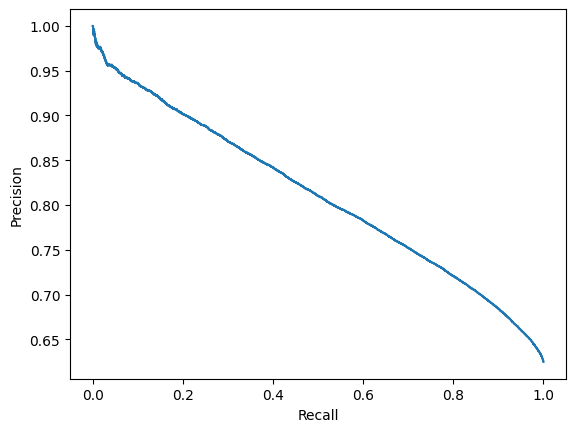

In [66]:
# Plotting PR curve for the Gradient Descent Model
prec_gd, recall_gd, threshold_gd = precision_recall_curve(y_valid, y_pred_hgd)

plt.figure()
plt.plot(recall_gd, prec_gd)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [67]:
# Tuning the Hyper Parameters using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameters = { 
    "hist_gradient_descent__learning_rate" : [0.02, 0.05, 0.1],
    "hist_gradient_descent__max_iter" : [200, 300, 500],
    "hist_gradient_descent__max_depth" :[5, 6, 8],
    "hist_gradient_descent__min_samples_leaf" : [15, 20],
    "hist_gradient_descent__l2_regularization" : [0.6, 0.65, 0.7 ,0.75, 0.8 ]
}

search_val = RandomizedSearchCV(hist_grad_pipeline, param_distributions=parameters, random_state=1, cv = 3, n_iter = 15, n_jobs=-1, scoring='roc_auc')

search_val.fit(X_train, y_train)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=1))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'hist_gradient_descent__l2_regularization': [0.6, 0.65, ...], 'hist_gradient_descent__learning_rate': [0.02, 0.05, ...], 'hist_gradient_descent__max_depth': [5, 6, ...], 'hist_gradient_descent__max_iter': [200, 300, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across 

In [68]:
best_params = search_val.best_params_
best_score = search_val.best_score_

print(best_params)
print(best_score)

{'hist_gradient_descent__min_samples_leaf': 20, 'hist_gradient_descent__max_iter': 300, 'hist_gradient_descent__max_depth': 5, 'hist_gradient_descent__learning_rate': 0.1, 'hist_gradient_descent__l2_regularization': 0.6}
0.7228729482962666


In [22]:
best_params_model = search_val.best_estimator_
y_pred_best = best_params_model.predict_proba(X_valid)[:,1]

ll_best = log_loss(y_valid, y_pred_best)
print(ll_best)

0.5862275678215122


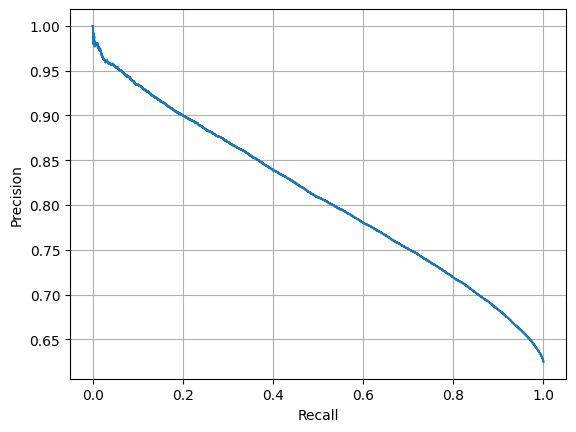

In [24]:
# Plotting PR curve for the best params Gradient Descent Model
prec_best, recall_best, threshold_best = precision_recall_curve(y_valid, y_pred_best)

plt.figure()
plt.plot(recall_best, prec_best)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

In [9]:
# Finalising the model and test our results with best params
test_data = pd.read_csv("../data/raw/test.csv", index_col='id')

processing = preprocess_data(num_cols=num_cols, ordinal_cat_cols=ordinal_cat_cols, nominal_cat_cols=nominal_cat_cols)
final_model_l2 = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.1, max_depth=5, random_state=1, min_samples_leaf=20, l2_regularization=0.6)

final_pipeline_l2 = Pipeline(steps=[("preprocessing", processing),
                                 ("model", final_model_l2)])

final_pipeline_l2.fit(X, y)

final_pred_l2 = final_pipeline_l2.predict_proba(test_data)[:,1]

In [ ]:
final_result_l2 = pd.DataFrame({"id": test_data.index,
                             "diagnosed_diabetes": final_pred_l2})

final_result_l2.to_csv("../submissions/submission_avg.csv", index=False)

In [10]:
final_model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.1, max_depth=5, random_state=1, min_samples_leaf=20)

final_pipeline = Pipeline(steps=[("preprocessing", processing),
                                 ("model", final_model)])

final_pipeline.fit(X, y)

final_pred = final_pipeline.predict_proba(test_data)[:,1]

In [11]:
#Averaging out both values from above
prediction = (final_pred + final_pred_l2)/2
final_result = pd.DataFrame({"id": test_data.index,
                             "diagnosed_diabetes": prediction})

final_result.to_csv("../submissions/submission_avg.csv", index=False)